In [4]:

# from transformers import ViTFeatureExtractor
# feature_extractor = ViTFeatureExtractor.from_pretrained('/home/zx/.cache/huggingface/transformers/vit-base-patch16-224-in21k')



from datasets import load_dataset
load_dataset('cifar100')

Found cached dataset cifar100 (/home/zx/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)
100%|██████████| 2/2 [00:00<00:00, 489.22it/s]


DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})

In [14]:
import numpy as np
import torch
import os
from natsort import os_sorted

image_path = 'benchmark/images'
# image_path = '/home/zx/atsp/ATSPrivacy-new/benchmark/'
test = dict()
a = os_sorted(os.listdir(image_path))
for dirname in a:
    if dirname.startswith('data_') and os.path.exists(f'{image_path}/{dirname}/metric.npy'):
        content = np.load(f'{image_path}/{dirname}/metric.npy',allow_pickle=True).tolist()

        psnr = []
        for item in content:
            psnr.append(item['test_psnr'] )
        
        # test[dirname.split('_')[-3]] = np.mean(psnr)
        # test[dirname] = np.mean(psnr)
        test[dirname] = np.mean(psnr)
        test[dirname] = [np.mean(psnr[:100]), len(psnr)]


for key, value in test.items():
    print(key, value)

data_CelebA_arch_ResNet18_tv_epoch_2_optim_inversed_large_mode_normal_auglist__rlabel_False [18.37848345756531, 100]
data_cifar100_arch_vit_epoch_10_optim_inversed_large_mode_aug_auglist_3-2-38_rlabel_False_fix [8.076161926442927, 11]
data_cifar100_arch_vit_epoch_10_optim_inversed_large_mode_normal_auglist__rlabel_False [12.579375429153442, 100]
data_ImageNet_arch_ResNet18_tv_epoch_30_optim_inversed_large_mode_aug_auglist_7-4-15_rlabel_False_fix [11.96839229106903, 100]
data_ImageNet_arch_ResNet18_tv_epoch_30_optim_inversed_large_mode_aug_auglist_18-9-37_rlabel_False_fix [12.271289196420224, 47]
data_ImageNet_arch_ResNet18_tv_epoch_30_optim_inversed_large_mode_aug_auglist_21-13-3_rlabel_False_fix [10.389964208602905, 100]
data_ImageNet_arch_ResNet18_tv_epoch_30_optim_inversed_large_mode_aug_auglist_24-15-48_rlabel_False_fix [10.787540373594865, 46]
data_ImageNet_arch_ResNet18_tv_epoch_30_optim_inversed_large_mode_aug_auglist_37-18-26_rlabel_False_fix [13.47081274456448, 36]
data_ImageN

In [15]:
def get_name_from_sh(sh_file):
    with open(sh_file) as f:
        for command in f.readlines():
            if len(command.split(' ')) > 2:
                c = command.split(' ')[3][11:]
                yield c
                    

# g = get_name_from_sh('/home/zx/New_atsp/ATSPrivacy-new/batch_cifar100_5000.sh')
g = get_name_from_sh('batch_ResNet_ImageNet.sh')

num_gpu = 7

aug_list = []
for c in g:
    if '50' not in c:
        # print(c)
        aug_list.append(c + '\n')



aug_per_file = len(aug_list) // num_gpu


for i in range(num_gpu):
    with open(f'candidate_policies_{i}.txt', 'w') as f:
        f.writelines(aug_list[aug_per_file*i : aug_per_file*(i+1)])

with open(f'candidate_policies_{num_gpu-1}.txt', 'a') as f:
    f.writelines(aug_list[aug_per_file*(i+1):])

# execlude = ['', '\n']

# with open(f'candidate_policies_0.txt', 'r') as f:
#     # f.writelines(aug_list[aug_per_file*(i+1):])
#     a = list(f.readlines())

# print(len(a))
# print(type(a[354]))
# b = filter(lambda x: x not in execlude, a)

# print(len(list(b)))


# a[354]





In [5]:
import numpy as np
from shutil import copyfile
src_dir = '/home/zx/data/GitRepo/ATSPrivacy/accuracy/data_cifar100_arch_vit'
dst_dir = '/home/zx/data/GitRepo/ATSPrivacy/accuracy/data_ImageNet_arch_ResNet18_tv'

# if not os.path.exists(dst_dir):
#     os.mkdir(dst_dir)

import os

a = os.listdir(src_dir)
b = os.listdir(dst_dir)
idx = 0
for name in a:
    if name not in b:
        # print(name)
        idx += 1
        
print(idx)
        



91


In [7]:
import pytorch_lightning as pl
import torchvision, torch

class LitModule(pl.LightningModule):
    def __init__(self, model, loss_fn, optimizer, scheduler):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        # self.opt    = opt

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward

        imgs, labels = batch
        labels = labels.to(torch.float32)
        preds = self.model(imgs)
        # print(preds.dtype, labels.dtype)
        loss = self.loss_fn(preds, labels)


        # acc = (preds.argmax(dim=-1) == labels).float().mean()
        # self.log('train_acc', acc)
        # self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_fn(preds, labels)
        # acc = (preds.argmax(dim=-1) == labels).float().mean()

    #     self.log('vaild_acc', acc)
    #     self.log('vaild_loss', loss)

    def configure_optimizers(self):
        return [self.optimizer], [self.scheduler]


model = torchvision.models.resnet18()
model.fc =  torch.nn.Linear(model.fc.in_features, 2)

dataset_root = '/home/zx/data'
tfms = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                           torchvision.transforms.ToTensor()])




train_ds = torchvision.datasets.CelebA(dataset_root, split='train', transform=tfms)
valid_ds = torchvision.datasets.CelebA(dataset_root, split='valid', transform=tfms)

train_dataloader = torch.utils.data.DataLoader(train_ds, shuffle = True, batch_size = 64, num_workers = 3)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, shuffle = False, batch_size = 64, num_workers = 3)



optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
                            weight_decay=5e-4, nesterov=True)


epochs=100
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                    milestones=[epochs // 2.667, epochs // 1.6,
                                                                epochs // 1.142], gamma=0.1)

loss_fn = torch.nn.BCEWithLogitsLoss()

model = LitModule(model, loss_fn, optimizer, scheduler)

trainer = pl.Trainer(accelerator="gpu",
                devices=[1],
                max_epochs=epochs,
                # logger=tb_logger,
                # val_check_interval=0.2,
                # log_every_n_steps=50,
                # log_every_n_steps=10, # for tiny imagenet training
                # callbacks=[
                #     ModelCheckpoint(
                #         save_top_k = 1,
                #         dirpath=save_dir,
                #         filename='{epoch:03d}-{vaild_acc:.4f}',
                #         every_n_epochs = int(0.1 * defs.epochs),
                #         save_last=True,
                        # save_on_train_epoch_end=True
                    # )
                    # ]
                )

trainer.fit(model, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/zx/data/GitRepo/ATSPrivacy/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.788    Total estimated model params size (MB)


Epoch 0:  41%|████      | 1045/2544 [01:31<02:11, 11.42it/s, loss=0.251, v_num=0]

In [1]:
import numpy as np
content = np.load('/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/data_CelebAFaceAlign_MLabel_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_aug_auglist_3-2-38_rlabel_False/metric.npy', allow_pickle=True)
# np.mean(content)
# len(content)
content

/home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array([{'test_mse': array(0.03284995, dtype=float32), 'feat_mse': tensor(2.1172, device='cuda:0'), 'test_psnr': 14.8346529006958},
       {'test_mse': array(0.0167456, dtype=float32), 'feat_mse': tensor(0.0293, device='cuda:0'), 'test_psnr': 17.76099395751953},
       {'test_mse': array(0.01383179, dtype=float32), 'feat_mse': tensor(0.0061, device='cuda:0'), 'test_psnr': 18.591217041015625},
       {'test_mse': array(0.02342128, dtype=float32), 'feat_mse': tensor(0.0308, device='cuda:0'), 'test_psnr': 16.30389404296875},
       {'test_mse': array(0.06921734, dtype=float32), 'feat_mse': tensor(1.2881, device='cuda:0'), 'test_psnr': 11.597851753234863},
       {'test_mse': array(0.01326529, dtype=float32), 'feat_mse': tensor(0.0148, device='cuda:0'), 'test_psnr': 18.7728328704834},
       {'test_mse': array(0.00967219, dtype=float32), 'feat_mse': tensor(0.0815, device='cuda:0'), 'test_psnr': 20.144750595092773},
       {'test_mse': array(0.08234712, dtype=float32), 'feat_mse': tensor(0.2

In [32]:
import torch
g_56 = torch.load('gradient_56.pt')
g_112 = torch.load('gradient_112.pt')
g_224 = torch.load('gradient_224.pt')

# a, b = g_56[60], g_224[0]

scalar_product = g_56[0].new_zeros(1,)
a_norm = g_56[0].new_zeros(1,)
b_norm = g_56[0].new_zeros(1,)

for a, b in zip(g_56, g_112):
    scalar_product = (a * b).sum()
    a_norm = a.pow(2).sum()
    b_norm = b.pow(2).sum()
 
    similarity = scalar_product / (a_norm.sqrt() * b_norm.sqrt())
    
    # print(similarity)

print(a, b)

tensor([ 0.1851, -0.1851], device='cuda:0') tensor([ 0.0607, -0.0607], device='cuda:0')


(5.0, 25.0)

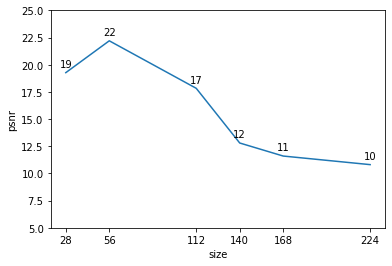

In [12]:
# weights = torch.arange(0, 62, 1, dtype=torch.float32) / 62
# weights

import matplotlib.pyplot as plt

y = [19.27, 22.20, 17.83, 12.80, 11.60, 10.81]
x = [i for i in range(len(y))]
x_ticks = [28, 56, 112, 140, 168, 224]

plt.plot(x_ticks, y)
plt.ylabel('psnr')
plt.xlabel('size')
plt.xticks(x_ticks)


for i, v in enumerate(y):
    plt.text(x_ticks[i], v+0.5, "%d" %v, ha="center")
plt.ylim(5, 25)

In [ ]:
from pathlib import Path
img_suffixs = ['.png', '.jpg']
path = Path('/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/data_ImageNet_arch_ResNet18_tv_epoch_30_optim_inversed_large_mode_normal_auglist__rlabel_False')
match = path.glob('ori*.png')
for i in match:
    print(i)
# indexs = [m.stem.split('_')[1]  for m in match if m.suffix in img_suffixs]

    

## Plot PSNR

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading 

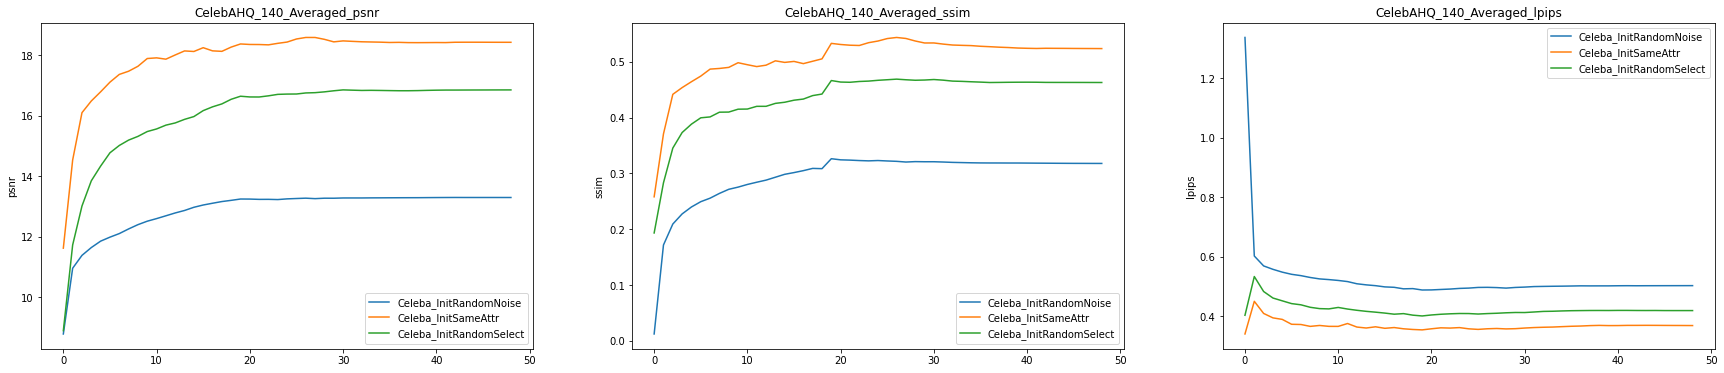

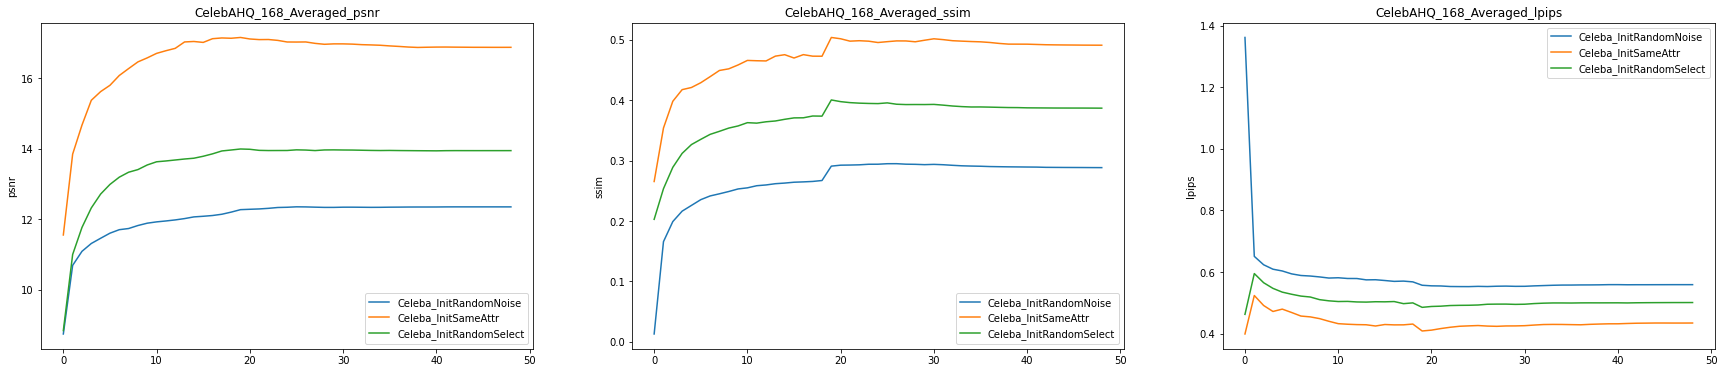

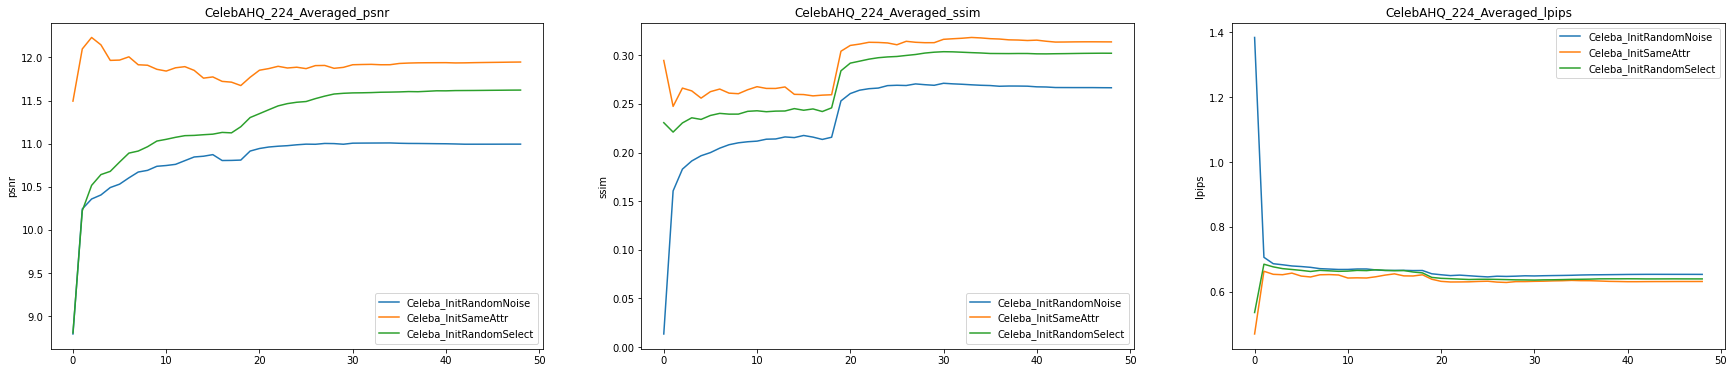

In [24]:
import utils_img
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import lpips
import torchvision, torch
import os
import natsort
import warnings
warnings.filterwarnings('ignore')

def draw_metric(method='psnr',reconstructed_imgs_path=None, origin_imgs_path=None, plot=True, label=''):

    ori_img = np.array(Image.open(origin_imgs_path))
    metric_list = []

    if method == 'lpips':
        loss_fn = lpips.LPIPS(net='alex')
        
    for img_path in reconstructed_imgs_path:
        rec_img = np.array(Image.open(img_path))
        if method == 'psnr':
            metric_list.append(utils_img.calculate_psnr(ori_img, rec_img))       
        elif method == 'ssim':
            metric_list.append(utils_img.calculate_ssim(ori_img, rec_img))       
        elif method == 'lpips':
            ori_img_th = torchvision.io.read_image(origin_imgs_path).to(dtype=torch.float32)
            rec_img_th = torchvision.io.read_image(img_path).to(dtype=torch.float32)

            ori_img_th = (ori_img_th -128 )/128
            rec_img_th = (rec_img_th - 128) /128
            score = loss_fn(ori_img_th.unsqueeze(0), rec_img_th.unsqueeze(0)).detach().item()
            metric_list.append(score)
        elif method == 'mse':
            
            ori_img_th = torchvision.io.read_image(origin_imgs_path).to(dtype=torch.float32)
            rec_img_th = torchvision.io.read_image(img_path).to(dtype=torch.float32)

            mse_score = (ori_img_th - rec_img_th).pow(2).mean(dim=[1, 2, 3])
            avg_mse, max_mse = mse_score.mean().item(), mse_score.max().item()
            metric_list.append(avg_mse)
        else:
            raise NotImplementedError(f'The method of {method} not implemented yet.')
            
    if plot: 
        plt.figure()
        plt.plot(range(len(metric_list)), metric_list, label=label)
        plt.ylabel(method)
    
    return metric_list

# draw single idx for different methods
"""
method = "psnr" 
idxs = []
for idx in idxs:
    plt.figure()
    for scale in [140, 168, 224]:
        origin_imgs_path = f'/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_{scale}_verbose/ori_{idx}.png'
        reconstructed_imgs_path = natsort.os_sorted(utils_img.get_image_paths(f'/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_{scale}_verbose/{idx}'))
        draw_metric(method=method, reconstructed_imgs_path=reconstructed_imgs_path, origin_imgs_path=origin_imgs_path, label=f'celeba_hq_{scale}')
    
    
    plt.title(f'{idx}') 
    plt.legend()
    
    # break 

"""


#draw average idxs for different methods



def draw_aveage_metric(idxs, result_imgs_dir, method):
    metric_lists = []
    for idx in idxs:
        # break
        origin_imgs_path = os.path.join(result_imgs_dir, f"ori_{idx}.png")
        reconstructed_imgs_path = natsort.os_sorted(utils_img.get_image_paths(os.path.join(result_imgs_dir, f"{idx}")))
        # print(reconstructed_imgs_path)
        # exit(0)

        metric_lists.append(draw_metric(method=method, reconstructed_imgs_path=reconstructed_imgs_path, origin_imgs_path=origin_imgs_path, label=None, plot=False))
        
    average_metric = np.mean(metric_lists, axis=0)

    return average_metric



def draw_aveage_metric_random_select(idxs, result_imgs_dir, method):

    metric_list = []
    for idx in idxs:
        # break
        imgs_dir = os.path.join(result_imgs_dir, f"{idx}")
        metric_list_for_same_img = []
        for subdir in os.listdir(imgs_dir):
            imgs_path = natsort.os_sorted(utils_img.get_image_paths(os.path.join(imgs_dir, subdir)))
            origin_imgs_path = imgs_path[-2]
            reconstructed_imgs_path = imgs_path[:-3]
            metric_list_for_same_img.append(draw_metric(method=method, reconstructed_imgs_path=reconstructed_imgs_path, origin_imgs_path=origin_imgs_path, label=None, plot=False))
        
        metric_list.append(np.mean(metric_list_for_same_img, axis=0))
    average_metric = np.mean(metric_list, axis=0)
    
    return average_metric





## idxs = [51, 54, 73, 94, 112, 124, 129, 132, 134, 140]


methods = ["psnr", "ssim","lpips"]
scales = [140, 168,224]


for scale in scales:
    
    plt.figure(figsize=(10*len(methods),6))
    
    for i, method in enumerate(methods):


        idxs = range(1, 51)
        result_imgs_dir = f"/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_{scale}_verbose"
        average_metric = draw_aveage_metric(idxs=idxs,result_imgs_dir=result_imgs_dir,  method=method)
        plt.subplot(1, len(methods), i+1)
        plt.plot(range(len(average_metric)), average_metric, label="Celeba_InitRandomNoise",)



        idxs = [52, 55, 74, 95, 113, 125, 130, 133, 135, 141]
        result_imgs_dir = f"/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_{scale}_verbose_initSameAttr"
        average_metric = draw_aveage_metric(idxs=idxs,result_imgs_dir=result_imgs_dir, method=method)
        plt.subplot(1, len(methods), i+1)
        plt.plot(range(len(average_metric)), average_metric, label="Celeba_InitSameAttr")
        
        
        idxs = [52, 55, 74, 95, 113, 125, 130, 133, 135, 141]
        result_imgs_dir = f"/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_{scale}_verbose_initRandom"
        average_metric = draw_aveage_metric_random_select(idxs=idxs,result_imgs_dir=result_imgs_dir, method=method)
        plt.subplot(1, len(methods), i+1)
        plt.plot(range(len(average_metric)), average_metric, label="Celeba_InitRandomSelect")

        plt.ylabel(method)
        plt.title(f"CelebAHQ_{scale}_Averaged_{method}") 
        plt.legend()
    plt.savefig(f"./fig/CelebAHQ_{scale}.pdf")
    
    



# idxs = [52, 55, 74, 95, 113, 125, 130, 133, 135, 141]
# # idxs = [52]
# scale = 140
# result_imgs_dir = f"/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_{scale}_verbose_initRandom"
# draw_aveage_metric_random_select(idxs=idxs,result_imgs_dir=result_imgs_dir, label="Celeba_InitRandomSelect")
    
    

In [4]:
from PIL import Image
import os

img_dir = "/home/zx/data/celeba_hq/data256/"

same_idxs = [73, 1783]

# [51, 2392], [54, 2906], [73, 1783], [94, 699], [122, 1887], [124, 1479], [129, 250, 1035],


# same_idxs = [13, 7401]
# for idx in same_idxs:
#     img = Image.open(os.path.join(img_dir, f"{24001 + idx}.jpg"))
#     display(img)

# random select img
from random import randint
from collections import defaultdict
random_idx = defaultdict(list)
template = {51:[2392], 54:[2906], 73:[1783], 94:[699], 112:[1887], 124:[1479], 129:[250, 1035], 132:[2120, 2236], 134:[529], 140:[2263] }
for i in template.keys():
    for k in range(3):
        idx = randint(0, 3000)
        random_idx[i].append(idx)

print(random_idx)


defaultdict(<class 'list'>, {51: [1595, 2320, 125], 54: [803, 1288, 2082], 73: [320, 2581, 2624], 94: [968, 746, 2468], 112: [2902, 321, 2898], 124: [2556, 2892, 2703], 129: [1507, 1004, 1524], 132: [2379, 1832, 916], 134: [1621, 1495, 2945], 140: [2241, 285, 1908]})


array([ 8.89097061, 11.72420247, 13.01351107, 13.8463266 , 14.33314696,
       14.77270316, 15.01443199, 15.19227753, 15.31506402, 15.47502005,
       15.56097024, 15.68688513, 15.75984296, 15.87817137, 15.9702124 ,
       16.16684838, 16.29195312, 16.38875448, 16.54185095, 16.64295372,
       16.61883319, 16.61757543, 16.6561186 , 16.70459908, 16.71408851,
       16.71635221, 16.75133031, 16.7608883 , 16.78745167, 16.82287521,
       16.85257856, 16.84302419, 16.83432553, 16.83804126, 16.83403606,
       16.82903671, 16.82451321, 16.82456307, 16.82903587, 16.83687504,
       16.84280671, 16.84662174, 16.84684996, 16.84796309, 16.84899733,
       16.84969409, 16.85084428, 16.85140783, 16.8519781 ])

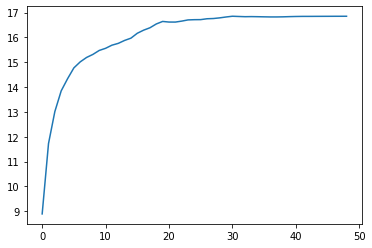

In [13]:

import utils_img
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import lpips
import torchvision, torch
import os
import natsort
import warnings
warnings.filterwarnings('ignore')
method = "psnr"
def draw_aveage_metric_random_select(idxs, result_imgs_dir, label):

    metric_list = []
    for idx in idxs:
        # break
        imgs_dir = os.path.join(result_imgs_dir, f"{idx}")
        metric_list_for_same_img = []
        for subdir in os.listdir(imgs_dir):
            imgs_path = natsort.os_sorted(utils_img.get_image_paths(os.path.join(imgs_dir, subdir)))
            origin_imgs_path = imgs_path[-2]
            reconstructed_imgs_path = imgs_path[:-3]
            metric_list_for_same_img.append(draw_metric(method=method, reconstructed_imgs_path=reconstructed_imgs_path, origin_imgs_path=origin_imgs_path, label=None, plot=False))
        
        metric_list.append(np.mean(metric_list_for_same_img, axis=0))
    average_metric = np.mean(metric_list, axis=0)
    

    # plt.subplot(1, len(methods), i+1)
    plt.plot(range(len(average_metric)), average_metric, label=label)
    return average_metric



idxs = [52, 55, 74, 95, 113, 125, 130, 133, 135, 141]
# idxs = [52]
scale = 140
result_imgs_dir = f"/home/zx/data/GitRepo/ATSPrivacy/benchmark/images/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_{scale}_verbose_initRandom"
draw_aveage_metric_random_select(idxs=idxs,result_imgs_dir=result_imgs_dir, label="Celeba_InitRandomSelect")

    

